In [1]:
from __future__ import print_function, division, absolute_import
import os,sys
import numpy as np
import time
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import h5py
import itertools
import orbithunter as orb


# This notebook requires Gudhi to have been installed; if this is not being accessed via Docker then it will not be installed by the default orbithunter requirements.

# Persistent Homology.

I am no expert on persistent homology but I will try to give a layman's overview. This discussion only covers
cubical complexes; i.e. what I used for discrete approximations of continuous fields. The main idea is to somehow
express topological information by scanning through the values the function takes. 

What does that mean? Imagine a topographic map (not to be confused with topology); that is, a height map which shows
the height above sea level. 

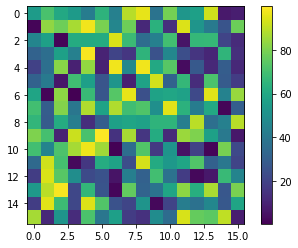

In [2]:
np.random.seed(0)
x = orb.OrbitKS().populate(spatial_modulation='gaussian', xscale=5, 
                           xvar=0.1, temporal_modulation='gaussian', tscale=5, tvar=0.1).transform(to='field')
x -= x.state.min()
np.random.seed(0)
tmp = 100*np.random.rand(16,16)
# for i in range(1, 5):
#     tmp[(tmp<=10*i)&(tmp>=10*(i-1))] = 10*i

plt.figure()
plt.imshow(tmp)
plt.colorbar()

Now, imagine filling up the map until everything is "underwater"

If we slowly drain the water, we will start to see "islands", much like how underwater volcanoes sometimes pop through the
surface, until we drain *all* of the water, at which point everything has gone from water to land. 

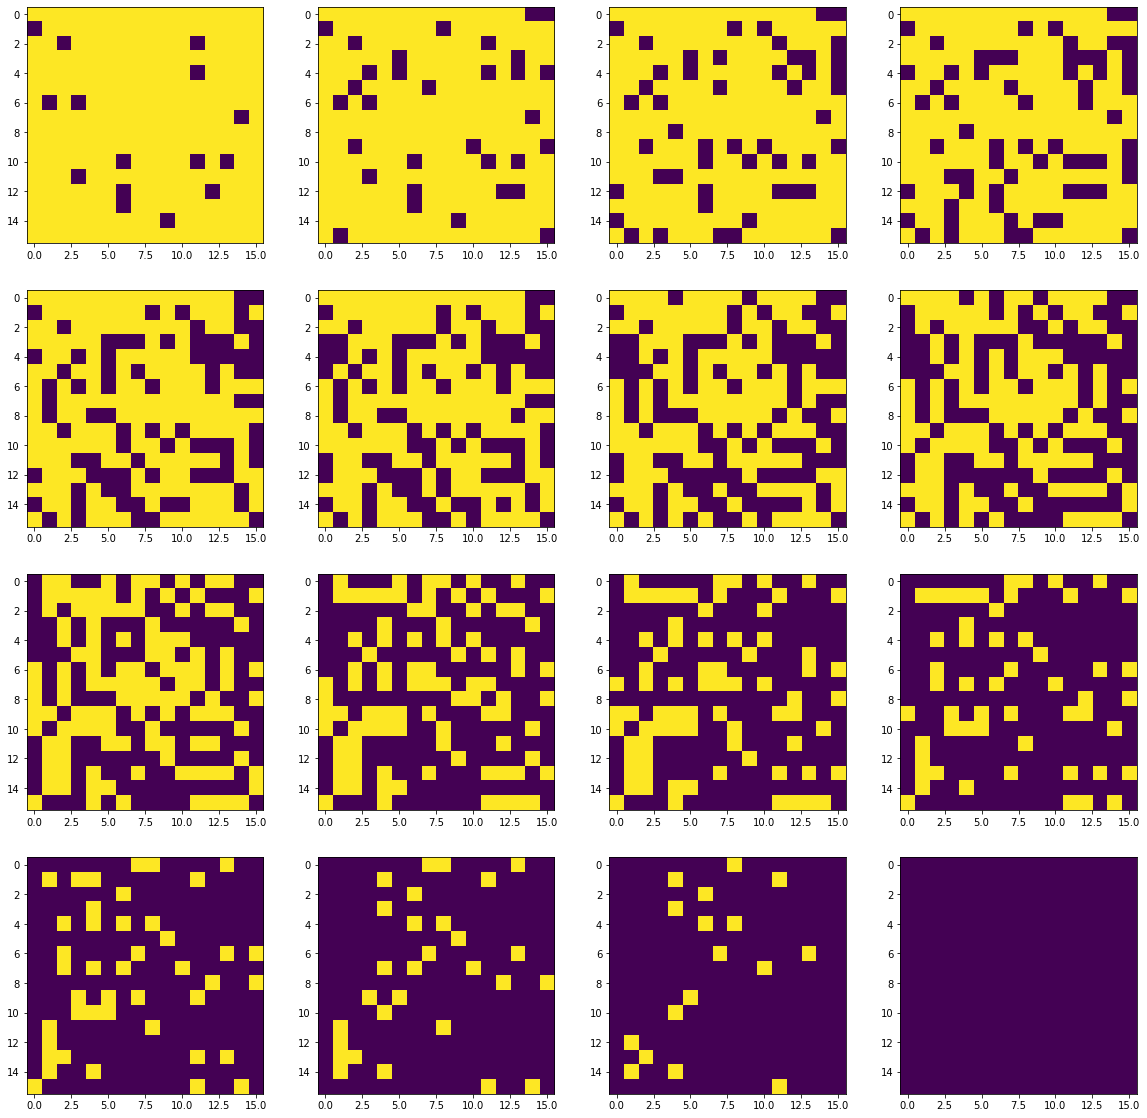

In [7]:

plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4, 4)
for i in range(16):
    ax = plt.subplot(gs[i])
    ax.imshow((tmp>tmp.max()*((i+1)/16)).astype(int), vmin=0, vmax=1)     
plt.show()

During the process of "turning the knob" of the field value, we see patterns start to emerge, and then disappear again. This is the basic idea behind persistent homology; programs revolve around detecting when these patterns are "born" and when they "die". When two patterns merge (imagine two lakes merging) they become a single pattern; this is also be detected and recorded. Now, 
the key piece of information comes from detecting patterns of different topologies. Islands would be connected components, or
0 dimensional holes. Rings would be 1-d holes, better known as circles; you can think of these as being rivers which wrap around the "world" for an example.

# Applying these ideas to periodic orbits and their patterns.

In higher dimensions, the "sea level" approach becomes a rasterization process. For example, cubes would be drawn instead of
two dimensional pixels. By going to a higher dimension, we can find more exciting structures like *cavities* which are born when a 3-d volume is enclosed; imagine a balloon or bubble in the air.

For fields which represent periodic solutions, we get a method for detecting patterns in an unsupervised manner; because this is very mathematical in nature, it also can incorporate aperiodic and periodic boundary conditions, i.e. a globe vs. a flat Earth (it is actually a good example here, ironically).
To show the results of such a detection, let's look at the combination of *persistence* plots and our sea-level plots; let's use a fundamental orbit as an example.

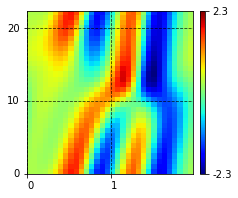

In [8]:
minimal_cover = orb.read_h5('./data/minimal_cover.h5')
# blown up for visibility
x = minimal_cover[2]
minimal_cover[2].plot(figsize=(3,3))

If we use the orbithunter wrapping of the Gudhi API, we can get a persistence diagram for this orbit.

In [9]:
from orbithunter.persistent_homology import persistence_plot

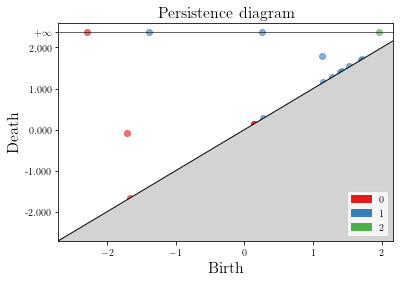

In [10]:
persistence_plot(minimal_cover[2], legend=True)

Let's decode what this describes. First, the further the scatter plot dots are from the 45 degree line, the more "persistent" the objects are. Second, the dots at the value $\infty$ indicate that they "never die". Going back to the sea level example,
if you fill in the entire Earth and then I ask how many lakes there are, you can still answer "1". Therefore, the 0th dimensional hole that is born at -2.5 or so and never dies corresponds to this phenomenon. 

Notice that there is a persistent 0 dimensional hole "born" around -1.8. Let's filter our array to see what is going on.
This time, however, I am going to start at the bottom and "fill up" the world instead of draining it.

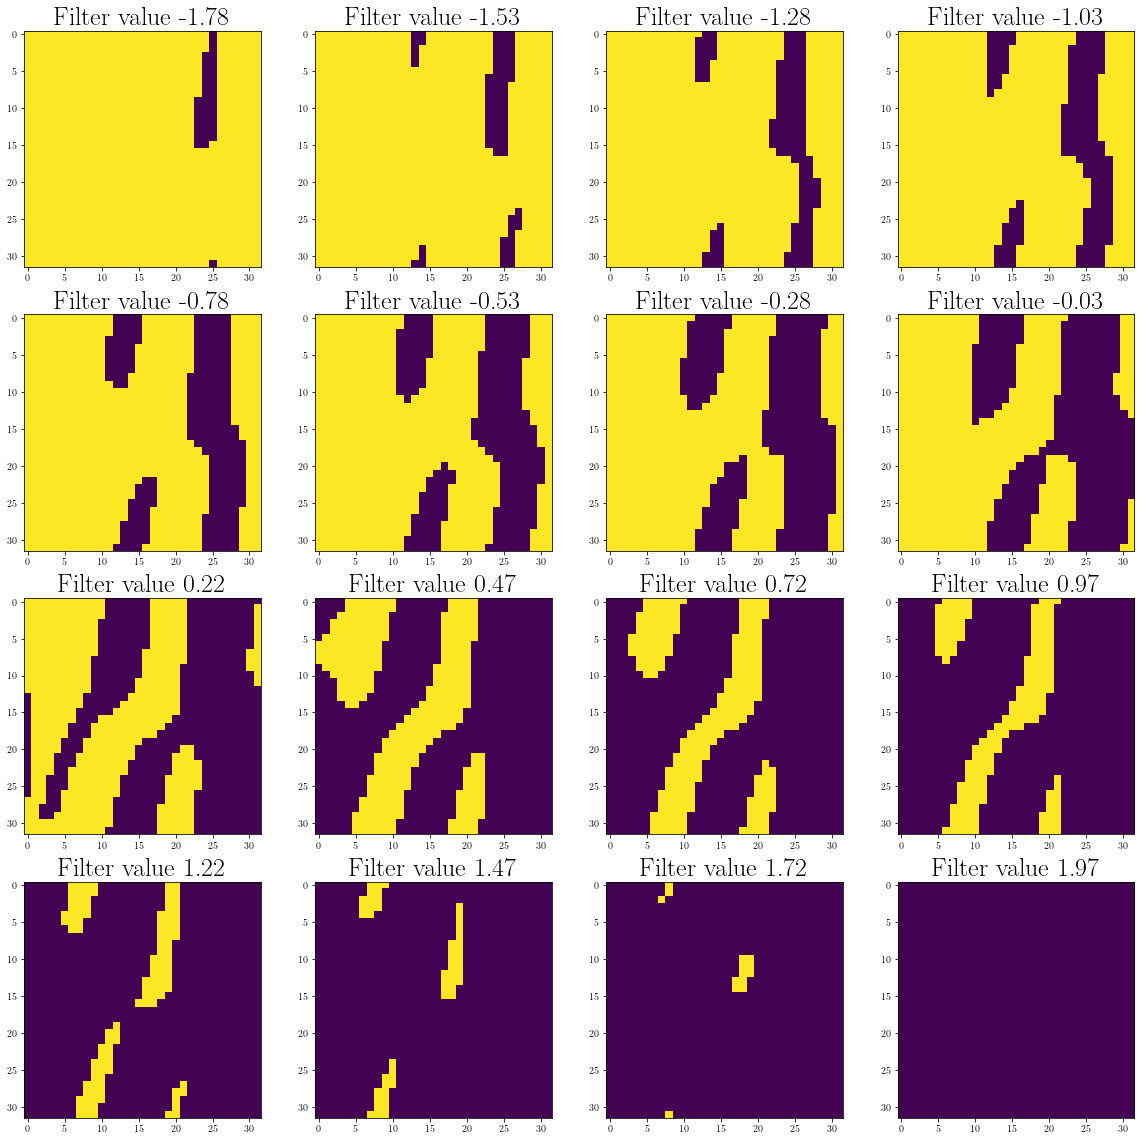

In [21]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4, 4)
for i in range(16):
    ax = plt.subplot(gs[i])
    ax.imshow((x.state>=x.state.min()+0.25*(i+2)).astype(int), vmin=0, vmax=1)
    ax.set_title(f"Filter value {x.state.min()+0.25*(i+2):.2f}", fontsize=26)
plt.show()

This might be slightly confusing because the boundaries are periodic, but notice that around -1.53, (first row, last column)
that there are 2 purple regions, after accounting for periodicity. Now, as the filter value increases, look at how those two regions remain distinct, until, that is, -0.03 (third row, second column). Therefore we should expect, because they merged, that one of the regions has "died". Which is true; notice that there is a red dot with death value around 0. When two objects A and B merge, which one "survives"? Seniority reigns; which ever was born earlier will survive. I.e. If A and B merge, and A is older than B, then we call the new region A and proceed.

# What are the benefits?

While I have yet to fully exploit this topological data analysis tool, one of the benefits of using it is that it provides a
perspective-free tool for identifying the patterns, that is, because of periodic boundary conditions, no matter how we rotate the "world" the map will be the same; the algorithm does not depend on absolute positions, just the "heights". Therefore, we can detect when two images/fields are related by some similarity transformation (within reason).

This is all quantified by their plots but also the distances between ***plots***

In [12]:
gxs = list(x.group_orbit(continuous=True, rolls=(16,16)))

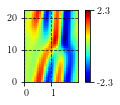

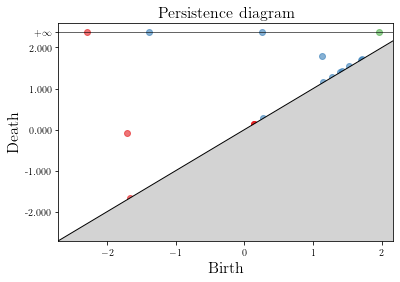

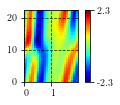

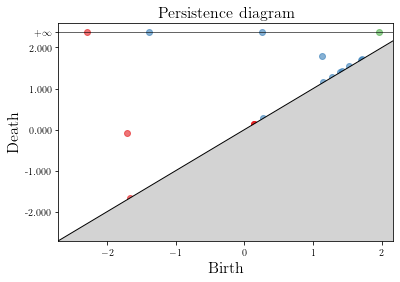

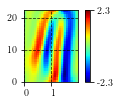

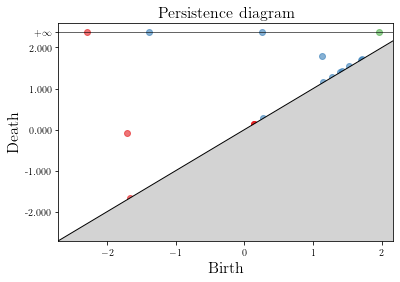

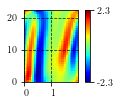

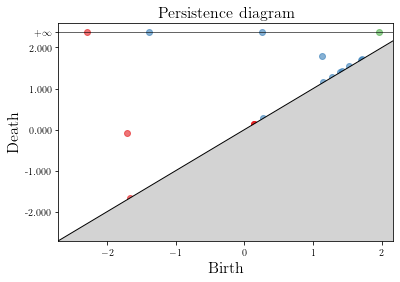

In [13]:
for gx in gxs:
    gx.plot()
    persistence_plot(gx)

In [14]:
from orbithunter.persistent_homology import persistence_distance

Even though the configurations of the fields are different; their diagrams are the same.

In [15]:
for i, gx in enumerate(gxs):
    dist = persistence_distance(gxs[0], gx)
    print(f"The distance between the first orbit's diagram and the {i}th orbit's diagram is {dist}")

The distance between the first orbit's diagram and the 0th orbit's diagram is 0.0
The distance between the first orbit's diagram and the 1th orbit's diagram is 0.0
The distance between the first orbit's diagram and the 2th orbit's diagram is 0.0
The distance between the first orbit's diagram and the 3th orbit's diagram is 0.0


Just to show that this is actually doing something, this is just a random example

In [16]:
dist = persistence_distance(gxs[0], minimal_cover[0])
print(f"The distance between the first orbit's diagram and the {i}th orbit's diagram is {dist}")

The distance between the first orbit's diagram and the 3th orbit's diagram is 0.6754981585227571


There are also other ways of encoding the persistence diagram, the barcode is particularly helpful in seeing how long different
events persist for. Here, the birth death are indicated by the endpoints of each bar; the y-axis simply enumerates the different events.

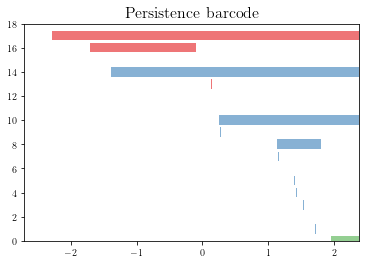

In [17]:
persistence_plot(gx, gudhi_method='barcode')

There are many other uses of this topological data analysis, but I haven't put them into any useful algorithms yet. 